In [1]:
from bayes_opt import BayesianOptimization
import os
import pandas as pd
import sys
import xarray as xr
import matplotlib.pyplot as plt

#from pathlib import Path
#home = str(Path.home())
#sys.path.append(home+"/UQ_python/metrics/")
#import metrics
from sklearn.metrics import mean_squared_error
#from xgboost import XGBRegressor
import numpy as np
from scipy.optimize import minimize

#import pyswarms as ps
#import cma
#from pyswarms.utils.functions import single_obj as fx
#from pyswarms.utils.plotters import plot_cost_history
#import matplotlib.pyplot as plt
#from geneticalgorithm import geneticalgorithm as ga

In [4]:
from cycler import cycler

my_cycler = (cycler(color=['#94c8d8','#FE9A84','#296540','#E63F39','#C3AAD1',
              '#D5AC5A','#F4B6C3','#B4BCCA','#DBD468','#B1D3E1','#8b1821']))
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['axes.prop_cycle'] = my_cycler
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18

# metrics

In [12]:
#model info

varlist_mod = ['PRECT']

path_mod = "/global/cscratch1/sd/zhangtao/E3SM/SCM_runs/e3sm_scm_ARM97_tune/run/"
fid_mod = xr.open_dataset(path_mod+"e3sm_scm_ARM97_tune.eam.h1.1997-06-19-84585.nc")
time_mod = fid_mod.time.values

In [13]:
varlist_obs = ['Prec']

path_obs = "/global/cfs/cdirs/e3sm/inputdata/atm/cam/scam/iop/"
fid_obs = xr.open_dataset(path_obs+"ARM97_iopfile_4scam.nc")
time_obs = np.datetime64('1997-06-18') + fid_obs.tsec.values
end = np.where(time_obs > np.datetime64('1997-07-16'))[0][0]
begin = np.where(time_obs < np.datetime64('1997-06-20'))[0][-1]

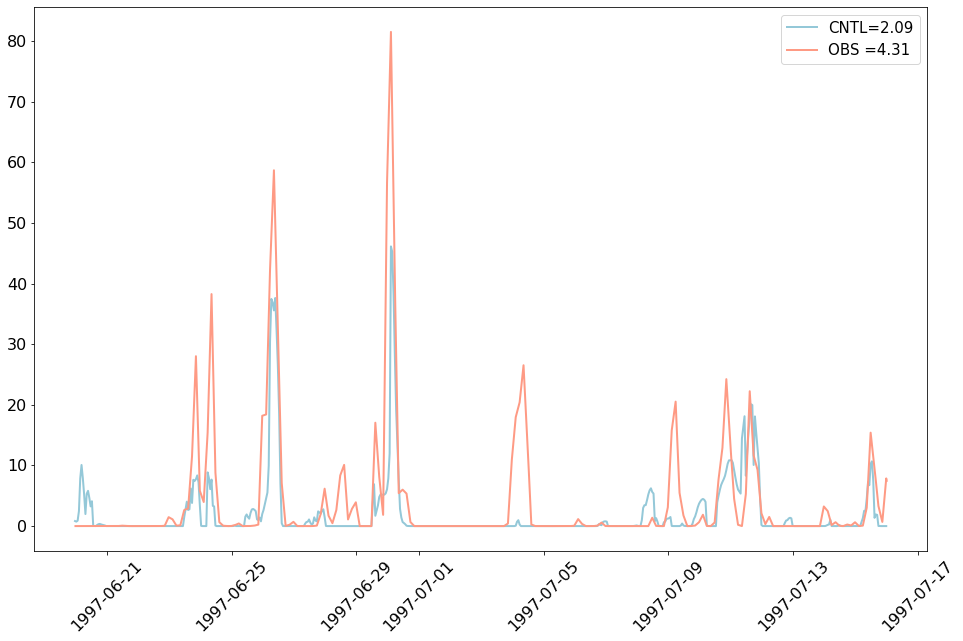

In [19]:
fig,axes = plt.subplots(1,1,figsize=(16,10))
for var in varlist_mod:
    var_mod = fid_mod[var].values
    
    if var == 'PRECT':
        var_mod = var_mod * 1000 * 86400
    
    mean_mod = np.mean(var_mod)
    axes.plot(time_mod,var_mod, label=f'CNTL={mean_mod:.2f}')
    
for var in varlist_obs:
    var_obs = fid_obs[var][:,0,0].values
    
    if var == 'Prec':
        var_obs = var_obs * 86400
    
    mean_obs = np.mean(var_obs)
    axes.plot(time_obs[begin:end],var_obs[begin:end],label=f'OBS ={mean_obs:.2f}')
    
axes.legend()
axes.tick_params(axis='x', labelrotation = 45)

# Turn framework

In [27]:
varlist_mod = ['PRECT']
path_mod = "/global/cscratch1/sd/zhangtao/E3SM/SCM_runs/e3sm_scm_ARM97_tune/run/"

varlist_obs = ['Prec']
path_obs = "/global/cfs/cdirs/e3sm/inputdata/atm/cam/scam/iop/"

In [24]:
#zmconv_c0_ocn, 
#zmconv_dmpdz

def scam_costfun():
    
    fid_mod = xr.open_dataset(path_mod+"e3sm_scm_ARM97_tune.eam.h1.1997-06-19-84585.nc")
    for var in varlist_mod:
        var_mod = fid_mod[var].values
    
        if var == 'PRECT':
            var_mod = var_mod * 1000 * 86400
    mean_mod = np.mean(var_mod)
    
    
    for var in varlist_obs:
        var_obs = fid_obs[var][:,0,0].values
    
        if var == 'Prec':
            var_obs = var_obs * 86400
    mean_obs = np.mean(var_obs)
    
    return np.abs(mean_mod-mean_obs)

def scam_run(x):
    os.chdir(path_mod)
    
    for key in x:
        replace_str = "sed -i '/\<"+key+"\>/c\ "+key+"="+str(x[key])+"' atm_in"
        os.system(replace_str)
        
    os.system("../build/e3sm.exe >& /dev/null")
    
    y = scam_costfun()
    
    return y
    
    

In [26]:
param_list = ['zmconv_c0_ocn','zmconv_dmpdz']
param_dict = {'zmconv_c0_ocn':'0.002', 'zmconv_dmpdz':'-0.7e-3'}

y = scam_run(param_dict)

In [39]:
X = data.loc[:,['vdis','beta_con']].values
y = data.loc[:,'chi'].values

In [198]:
X[:,1] = X[:,1]/10e22

# surrogate model

In [199]:
xgb = XGBRegressor(n_estimators=600, nthread=8, max_depth=7)

In [200]:
xgb.fit(X,y)
pred_y = xgb.predict(X)
m = mean_squared_error(pred_y,y)
print(m)
print(X.shape)

1.9239937523136003e-06
(327, 2)


# BayesianOpt

In [42]:
def fun1(vdis,beta_con):
    X = np.array([vdis,beta_con]).reshape(1,-1)
    pred_y = xgb.predict(X)
    return -pred_y[0]
    
#fun1(1.3,1.02E20)

In [246]:
pbounds = {'vdis': (0.01, 1.4), 'beta_con': (1.02E20, 1.67E24)}
pbounds = {'vdis': (0.001,0.01), 'beta_con': (1.02E20, 1.67E24)}
pbounds = {'vdis': (0.001,0.01), 'beta_con': (1.02E-2, 1.67E2)}

In [253]:
Boptimizer = BayesianOptimization(
    f=fun1,
    pbounds=pbounds,
    random_state=10,
)

In [254]:
Boptimizer.maximize(
    init_points=100,
    n_iter=200,
)

|   iter    |  target   | beta_con  |   vdis    |
-------------------------------------------------
|  1        | -1.488    |  128.8    |  0.001187 |
|  2        | -1.482    |  105.8    |  0.007739 |
|  3        | -1.477    |  83.26    |  0.003023 |
|  4        | -1.531    |  33.08    |  0.007845 |
|  5        | -1.65     |  28.25    |  0.001795 |
|  6        | -1.509    |  114.5    |  0.009581 |
|  7        | -1.316    |  0.6695   |  0.00561  |
|  8        | -1.426    |  135.7    |  0.006513 |
|  9        | -1.441    |  120.5    |  0.003627 |
|  10       | -1.417    |  153.3    |  0.007431 |
|  11       | -1.617    |  90.61    |  0.00228  |
|  12       | -1.443    |  62.35    |  0.007067 |
|  13       | -1.445    |  73.79    |  0.004906 |
|  14       | -1.52     |  103.2    |  0.005618 |
|  15       | -1.47     |  108.6    |  0.006409 |
|  16       | -1.513    |  134.5    |  0.005695 |
|  17       | -1.458    |  151.7    |  0.003873 |
|  18       | -1.47     |  15.12    |  0.003706 |


In [255]:
aa = np.zeros(300)
for i,r in enumerate(Boptimizer.res):
    aa[i] = -r['target']

bb = np.zeros(300)
bb[0] = aa[0]
for i in range(1,len(aa)):
    if aa[i] < bb[i-1]:
        bb[i] = aa[i]
    else:
        bb[i] = bb[i-1]

# nelder mead

In [46]:
def fun2(X):
    X = X.reshape(1,-1)
    pred_y = xgb.predict(X)
    return pred_y

In [47]:
x0 = np.array([0.002, 1.1281180989999998e+24])

initial_simplex = np.array([
    [1.311735, 1.1281180989999998e+24],
    [1.3103449999999999, 4.2008134699999996e+23],
    [0.869715, 1.4955787099999998e+23]
])

#res = minimize(fun2, x0, method='nelder-mead',
#               options={'xatol': 1e-8, 'disp': True, 'return_all':True})


res = minimize(fun2, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True, 'return_all':True})

In [48]:
print(res['x'])

[1.96875000e-03 1.18981206e+24]


In [49]:
print(res.allvecs)

[array([2.0000000e-03, 1.1281181e+24]), array([2.000000e-03, 1.184524e+24]), array([2.000000e-03, 1.184524e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.18981206e+24]), array([1.96875000e-03, 1.

In [50]:
for x in res.allvecs:
    print(x, fun2(x))

[2.0000000e-03 1.1281181e+24] [1.515225]
[2.000000e-03 1.184524e+24] [1.4908975]
[2.000000e-03 1.184524e+24] [1.4908975]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]
[1.96875000e-03 1.18981206e+24] [1.4896518]

# pyswarms

In [241]:
def fun3(X):
    pred_y = xgb.predict(X)
    return pred_y

In [242]:
#x_max = np.array([1.4, 1.67E24])
#x_min = np.array([0.01,1.02E20])
x_max = np.array([0.01, 1.67E2])
x_min = np.array([0.001,1.02E-2])
bounds = (x_min, x_max)
print(bounds)

(array([0.001 , 0.0102]), array([1.00e-02, 1.67e+02]))


In [274]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fun3, iters=300)

2021-10-12 21:49:36,307 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|300/300, best_cost=1.28
2021-10-12 21:49:38,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.284783124923706, best pos: [0.0094307  3.43602287]


# CMAES

In [201]:
def fun4(X):
    X = X.reshape(1,-1)
    pred_y = xgb.predict(X)
    return pred_y[0]

In [187]:
from cma import bbobbenchmarks as bn
f3 = bn.F3(14)
a  = f3([0, 1, 2])

print(type(a))

<class 'numpy.float64'>


In [203]:
a = fun4(np.array([2.0000000e-03,1.1281181e+2]))
print(type(a))
print(a)

<class 'numpy.float32'>
1.5617737


In [214]:
opts = cma.CMAOptions()
opts.set("bounds", [x_min, x_max])
#options = {'seed':12345, 'verb_time':0, 'ftarget': 1e-8,'bounds':[[4, 6]]}
xopt, es = cma.fmin2(fun4,[2.0000000e-03,1.1281181e+2], 0.009, opts,restarts=9)
print(xopt)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=911874, Sat Oct  9 03:11:20 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.456074953079224e+00 1.0e+00 7.17e-03  6e-03  6e-03 0:00.0
    2     12 1.449537873268127e+00 1.1e+00 7.40e-03  6e-03  7e-03 0:00.0
    3     18 1.426373481750488e+00 1.2e+00 7.59e-03  6e-03  9e-03 0:00.0
   82    492 1.399529576301575e+00 3.6e+00 8.69e-04  2e-05  3e-05 0:00.9
termination on tolflatfitness=1 (Sat Oct  9 03:11:21 2021)
final/bestever f-value = 1.399530e+00 1.399530e+00
incumbent solution: [0.008184671365868852, 112.8476737364401]
std deviation: [2.5701459210065725e-05, 2.434990206451715e-05]
(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=911875, Sat Oct  9 03:11:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    505 1.438180088996887e+00 1.0e+00 1.26e-02  1e-02  1e-02 0:00.0
    2    517 1.444671988487244e+00 1.8e+00 1.24e-02  1e-02  1e-02 0:00.0
  

# genetic algorithm

[[1.00e-03 1.02e-02]
 [1.00e-02 1.67e+02]]
 The best solution found:                                                                           
 [0.00581733 0.75501603]

 Objective function:
 1.2617230415344238


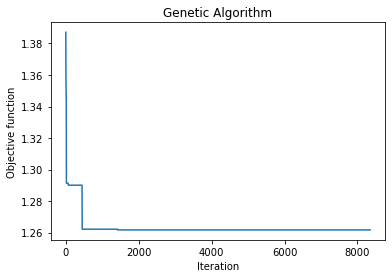

In [223]:
def f(X):
    print(X)
    print(X.shape)
    sys.exit()
    return np.sum(X)

varbound=np.array([x_min,x_max])
print(varbound)

model=ga(function=fun4,dimension=2,variable_type='real',variable_boundaries=varbound)

model.run()

 The best solution found:                                                                           
 [0.0093077  1.87625043]

 Objective function:
 1.2702229022979736


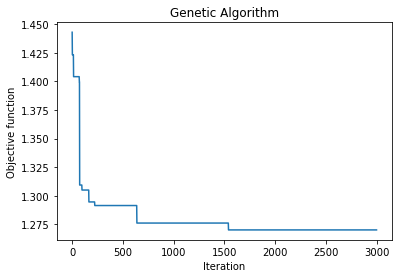

In [262]:
algorithm_param = {'max_num_iteration': 3000,\
                   'population_size':10,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
model1=ga(function=fun4,dimension=2,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

model1.run()

In [257]:
print(model.param)

{'max_num_iteration': None, 'population_size': 100, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}


In [263]:
convergence=model1.report
solution = model1.output_dict

In [237]:
print(len(convergence))
print(convergence[0])
print(solution)

8350
1.3871145248413086
{'variable': array([0.00581733, 0.75501603]), 'function': 1.2617230415344238}


(array([1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

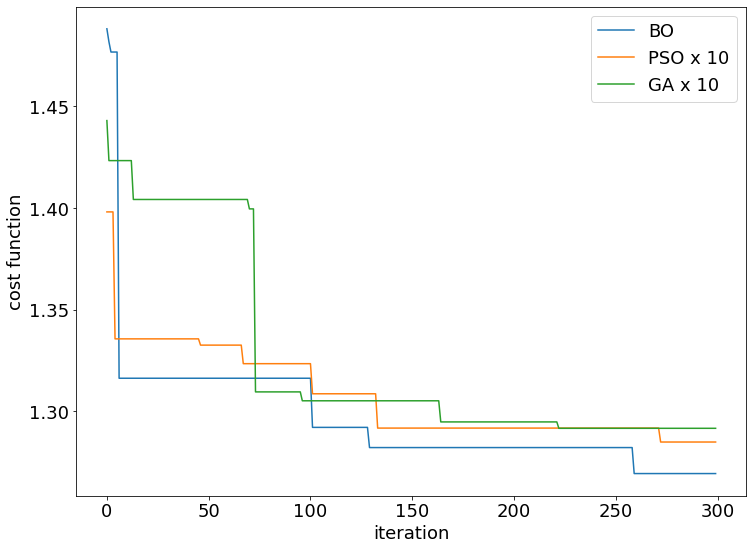

In [275]:

plt.figure(figsize=(12,9))
plt.plot(bb,label="BO")
plt.plot(optimizer.cost_history,label="PSO x 10")
plt.plot(convergence[:300],label="GA x 10")
plt.legend(fontsize=18)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('cost function', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [276]:
print(bb[-1])
print(optimizer.cost_history[-1])
print(convergence[300])

1.2692577838897705
1.284783124923706
1.2915337085723877


In [2]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [3]:
from bayes_opt import BayesianOptimization

In [4]:
pbounds = {'x': (2, 4), 'y': (-3, 3)}

In [5]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [6]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |


TypeError: 'float' object is not subscriptable

In [33]:
from scipy.optimize import minimize, rosen, rosen_der

In [34]:
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]

In [35]:
res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)

In [36]:
res.x

array([1.00000002, 1.00000002, 1.00000007, 1.00000015, 1.00000028])

In [38]:
res.fun[0]

IndexError: invalid index to scalar variable.